# Import libraries

In [21]:
import glob as gb
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,cv2
from keras.applications import InceptionV3
import random
import seaborn as sns

# Tensorflow
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import datasets,models,layers
from tensorflow.keras.models import Model, Sequential
from tensorflow import keras
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Activation , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

# sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Functions and global variables

In [2]:
def get_key_from_value(dictionary, value):
    return next((key for key, val in dictionary.items() if val == value), None)

def plot_accuracy_and_loss(history):
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']

    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    index_acc = np.argmax(val_acc)
    val_lowest = val_loss[index_loss]
    val_highest = val_acc[index_acc]

    epochs = [i+1 for i in range(len(train_acc))]
    loss_label = f'Best Epoch = {str(index_loss + 1)}'
    acc_loss = f'Best Epoch = {str(index_acc +1)}'

    #Training Accuracy
    plt.figure(figsize= (20,8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1,2,1)
    plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
    plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
    plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
    plt.title('Training Vs Validation (Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
    plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
    plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
    plt.title('Training Vs Validation (Accuracy)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def test_accuracy_and_loss(model):
    test_loss, test_acc = model.evaluate(test_img , test_lbl)

    # Calculate accuracy percentage
    accuracy_percentage = test_acc * 100
    print('Test accuracy: {:.2f}%'.format(accuracy_percentage), '    Test loss: ', test_loss)
    
def prediction_accuracy(model):
    #Prediction and accuracy check on test data
    predictions = model.predict(test_img)    
    pred_lbl = np.argmax(predictions, axis = 1)
    print("Model 1 Accuracy on test : {}".format(accuracy_score(test_lbl, pred_lbl)))
    return predictions, pred_lbl

# Define common size for resizing
common_size = (224, 224)

TotalClasses=6

early = EarlyStopping(patience=5, restore_best_weights=True)

train_folder = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_folder = "/kaggle/input/intel-image-classification/seg_test/seg_test"
pred_folder = "/kaggle/input/intel-image-classification/seg_pred"

# Pre-processing

In [3]:
# Your label mapping and file paths
labels = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

# Load training data
train_img = []
train_lbl = []

# Define common size for resizing
common_size = (224, 224)

for folder in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, folder)
    files = gb.glob(pathname=os.path.join(folder_path, "*.jpg"))
    for file in files:
        image = Image.open(file)
        image = image.resize(common_size)  # Resize image to a common size
        train_img.append(np.array(image))
        train_lbl.append(labels.get(folder, -1))

train_img = np.array(train_img)
train_lbl = np.array(train_lbl)

# Load testing data
test_img = []
test_lbl = []
for folder in os.listdir(test_folder):
    folder_path = os.path.join(test_folder, folder)
    files = gb.glob(pathname=os.path.join(folder_path, "*.jpg"))
    for file in files:
        image = Image.open(file)
        image = image.resize(common_size)  # Resize image to a common size
        test_img.append(np.array(image))
        test_lbl.append(labels.get(folder, -1))

test_img = np.array(test_img)
test_lbl = np.array(test_lbl)

# Load prediction data
pred_img = []
for folder in os.listdir(pred_folder):
    folder_path = os.path.join(pred_folder, folder)
    files = gb.glob(pathname=os.path.join(folder_path, "*.jpg"))
    for file in files:
        image = Image.open(file)
        image = image.resize(common_size)  # Resize image to a common size
        pred_img.append(np.array(image))

pred_img = np.array(pred_img)

# Check the number of items in each set and their shapes
print("Number of items in the training set:", len(train_img))
print("Number of items in the testing set:", len(test_img))
print("Number of items in the prediction set:", len(pred_img))

Number of items in the training set: 14034
Number of items in the testing set: 3000
Number of items in the prediction set: 7301


In [4]:
print("Shape of train_img:", train_img.shape)
print("Shape of train_lbl:", train_lbl.shape)
print("Shape of test_img:", test_img.shape)
print("Shape of test_lbl:", test_lbl.shape)
print("Shape of pred_img:", pred_img.shape)

Shape of train_img: (14034, 224, 224, 3)
Shape of train_lbl: (14034,)
Shape of test_img: (3000, 224, 224, 3)
Shape of test_lbl: (3000,)
Shape of pred_img: (7301, 224, 224, 3)


# Training data sample

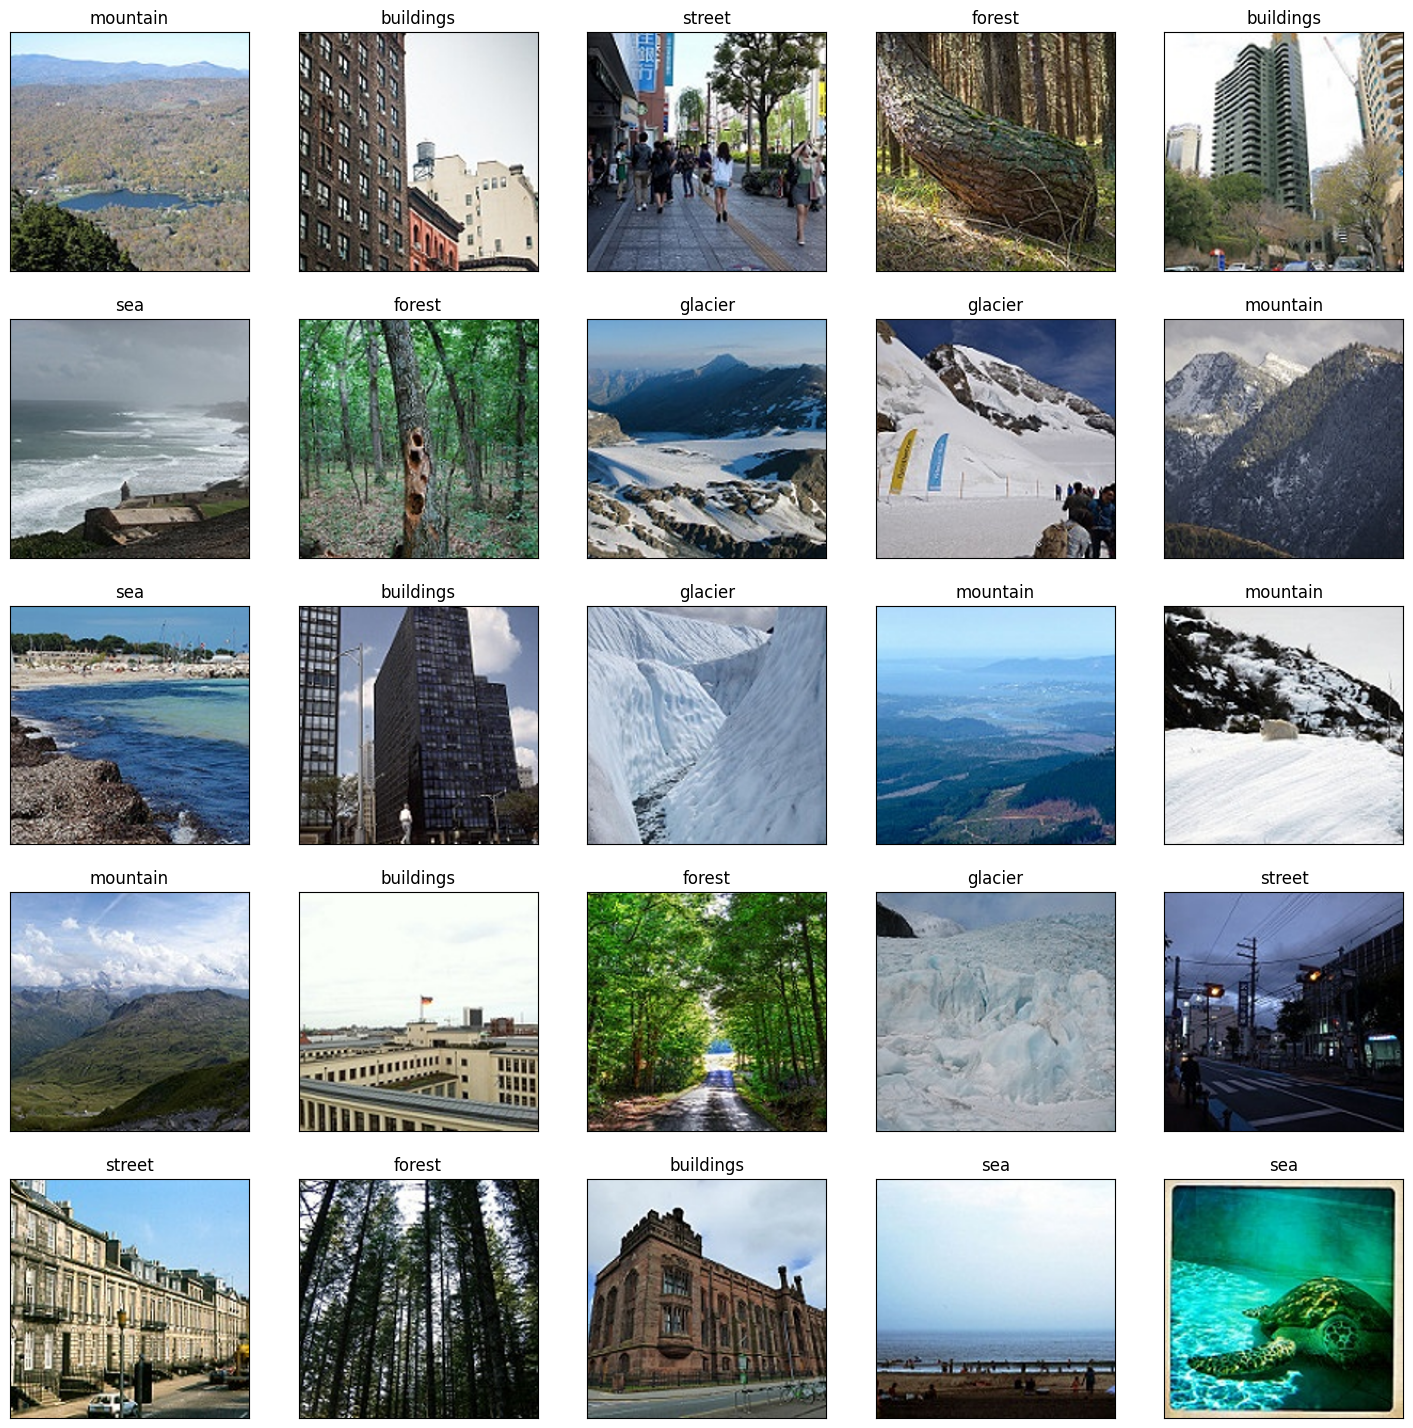

In [5]:
plt.figure(figsize=(18, 18))

random_list = random.sample(range(len(train_img)), 25)
i = 0
for j in random_list:
    plt.subplot(5, 5, i+1)
    plt.imshow(train_img[j])
    label_code = train_lbl[j]
    label_name = [key for key, value in labels.items() if value == label_code][0]
    plt.title(label_name)
    plt.xticks([])
    plt.yticks([])
    i+=1

plt.show()

# Pre-trained Inception

## Model 1

In [6]:
# Load InceptionV3 pre-trained on ImageNet
inception1 = InceptionV3(input_shape=train_img[0].shape, weights='imagenet', include_top=False)

# Freeze layers of the pre-trained model
for layer in inception1.layers:
    layer.trainable = False

# Unfreeze the last 100 layers for fine-tuning
for layer in inception1.layers[-100:]:
    layer.trainable = True

last_layer1 = inception1.get_layer('mixed7')
last_output1 = last_layer1.output

# Add custom classification head
x1 = layers.Flatten()(last_output1)
x1 = layers.Dense(1024, activation='relu')(x1)
x1 = layers.Dropout(0.2)(x1)                   
pred1=layers.Dense(TotalClasses,activation="softmax")(x1)
# Create the fine-tuned model
model1 = models.Model(inputs=inception1.input, outputs=pred1)
#model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [7]:
# compile the model
model1.compile(Adamax(learning_rate= 0.0001) , loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# Train the model
history1 = model1.fit(train_img, train_lbl, epochs=20, validation_data=(test_img, test_lbl), callbacks=[early])

Epoch 1/20
  3/439 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.2118 - loss: 2.1008 

I0000 00:00:1710385016.487508     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710385016.538526     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6025 - loss: 1.0638

W0000 00:00:1710385055.344341     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 70s 114ms/step - accuracy: 0.6026 - loss: 1.0634 - val_accuracy: 0.7063 - val_loss: 0.7825
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.7616 - loss: 0.6462 - val_accuracy: 0.7293 - val_loss: 0.7252
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.8176 - loss: 0.5139 - val_accuracy: 0.7477 - val_loss: 0.6956
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.8703 - loss: 0.3852 - val_accuracy: 0.7630 - val_loss: 0.6730
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.9009 - loss: 0.3013 - val_accuracy: 0.7623 - val_loss: 0.6810
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.9324 - loss: 0.2222 - val_accuracy: 0.7573 - val_loss: 0.7083
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.9479 - loss: 0.1750 - val_accuracy: 0.7603 - val_loss: 0.7365
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.9674 - loss: 0.1334 - val_accura

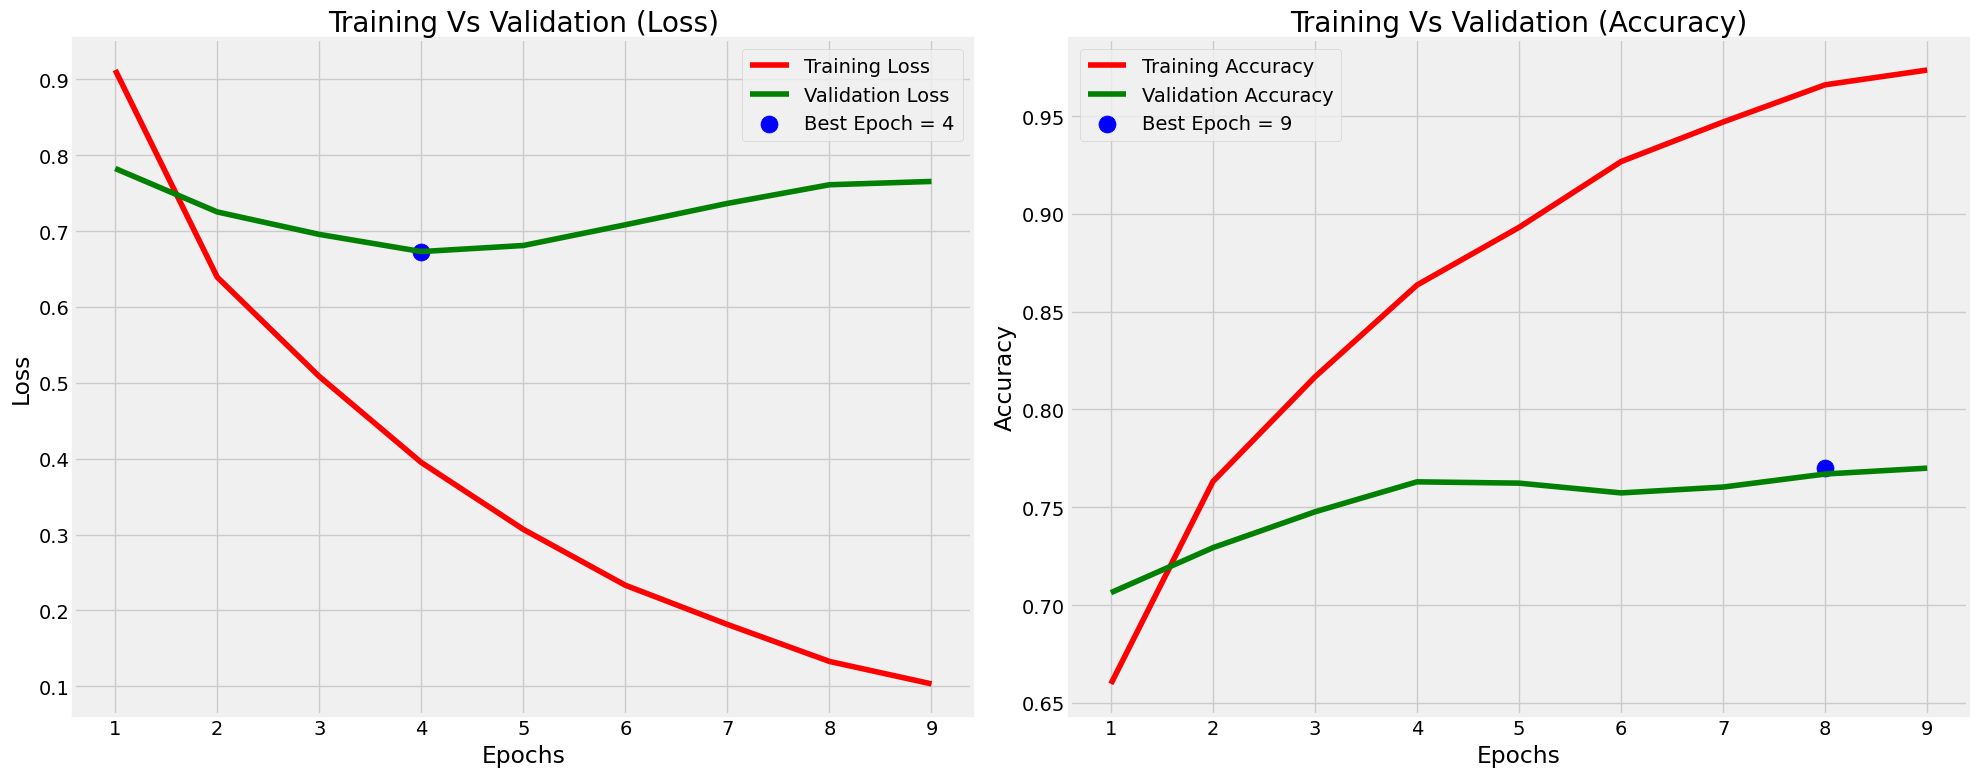

In [8]:
plot_accuracy_and_loss(history1)

In [9]:
test_accuracy_and_loss(model1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7245 - loss: 0.7752
Test accuracy: 76.30%     Test loss:  0.6729891896247864


## Model 2

In [10]:
# Load InceptionV3 pre-trained on ImageNet
inception2 = InceptionV3(input_shape=train_img[0].shape, weights='imagenet', include_top=False)

# Freeze layers of the pre-trained model
for layer in inception2.layers:
    layer.trainable = False

# Unfreeze the first 100 layers for fine-tuning
for layer in inception2.layers[100:]:
    layer.trainable = True

last_layer2 = inception2.get_layer('mixed7')
last_output2 = last_layer2.output

# Add custom classification head
x2 = layers.Flatten()(last_output2)
x2 = layers.Dense(1024, activation='relu')(x2)
x2 = layers.Dropout(0.2)(x2)                   
pred2=layers.Dense(TotalClasses,activation="softmax")(x2)
# Create the fine-tuned model
model2 = models.Model(inputs=inception2.input, outputs=pred2)
#model.summary()

In [11]:
# compile the model
model2.compile(Adamax(learning_rate= 0.0001) , loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# Train the model
history2 = model2.fit(train_img, train_lbl, epochs=20, validation_data=(test_img, test_lbl), callbacks=[early])

Epoch 1/20
  2/439 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.1484 - loss: 1.9553   

W0000 00:00:1710385322.659544     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6360 - loss: 0.9586

W0000 00:00:1710385378.626997     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


439/439 ━━━━━━━━━━━━━━━━━━━━ 95s 143ms/step - accuracy: 0.6362 - loss: 0.9582 - val_accuracy: 0.7743 - val_loss: 0.6153
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.8680 - loss: 0.3743 - val_accuracy: 0.7900 - val_loss: 0.6041
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9476 - loss: 0.1682 - val_accuracy: 0.7950 - val_loss: 0.6577
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.9814 - loss: 0.0787 - val_accuracy: 0.8027 - val_loss: 0.6732
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9910 - loss: 0.0391 - val_accuracy: 0.8060 - val_loss: 0.7755
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9925 - loss: 0.0312 - val_accuracy: 0.7983 - val_loss: 0.7950
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.9967 - loss: 0.0203 - val_accuracy: 0.8020 - val_loss: 0.8691


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7732 - loss: 0.6106
Test accuracy: 79.00%     Test loss:  0.6041049361228943


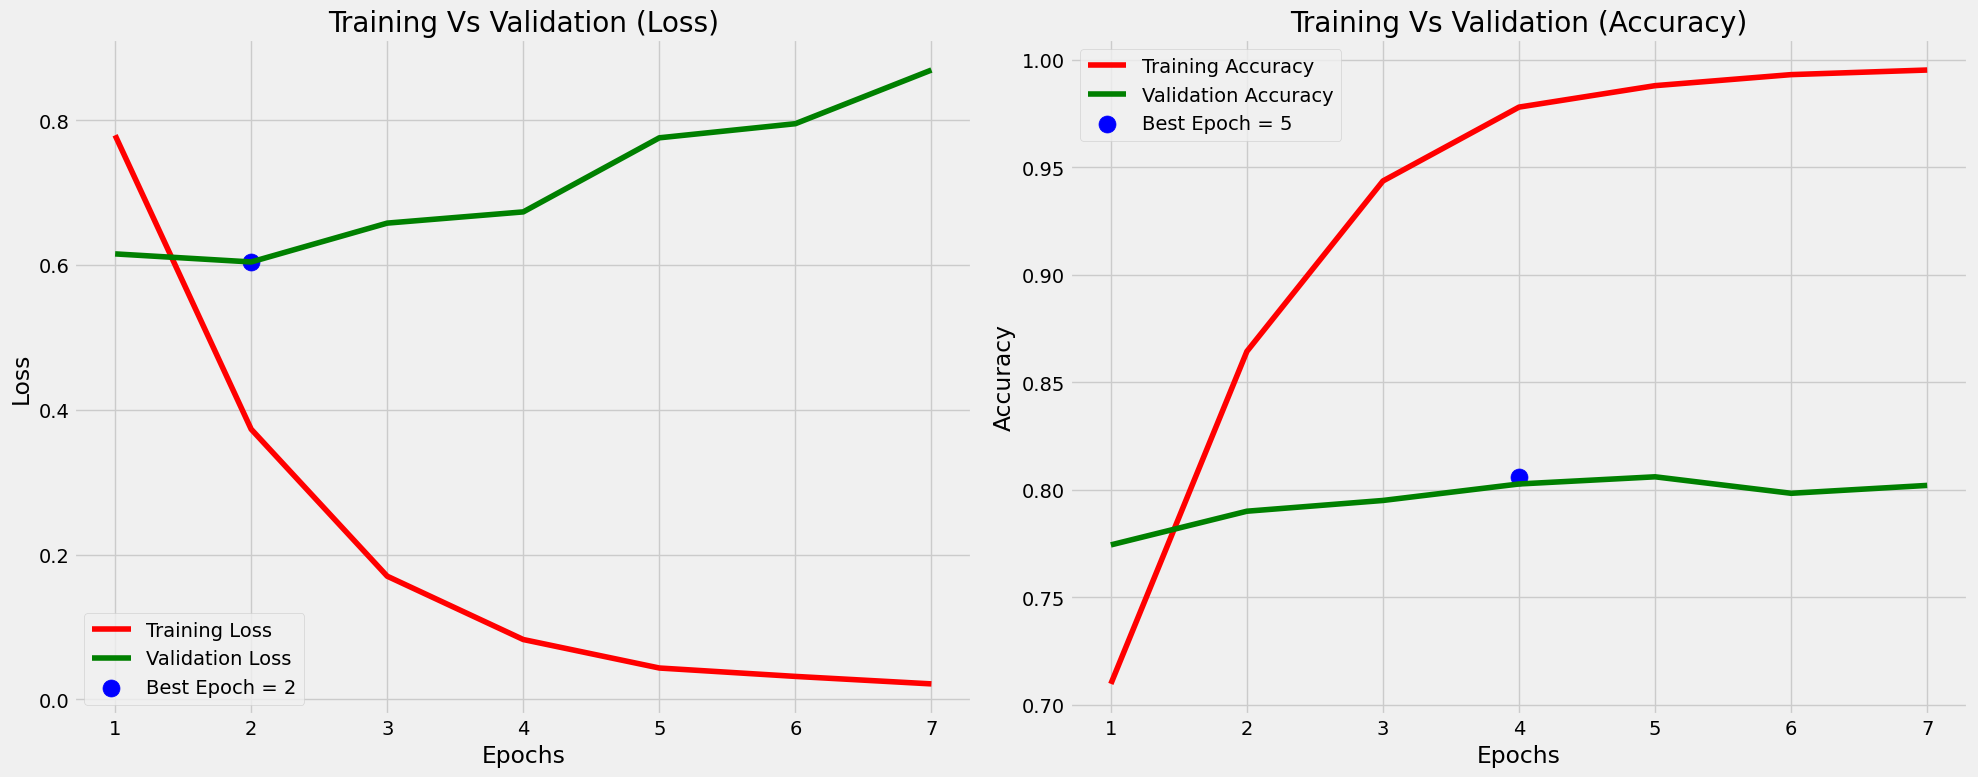

In [12]:
test_accuracy_and_loss(model2)
plot_accuracy_and_loss(history2)

## Model 3

In [13]:
# Load InceptionV3 pre-trained on ImageNet
inception3 = InceptionV3(input_shape=train_img[0].shape, weights='imagenet', include_top=False, pooling= 'max')

model3 = Sequential([
    inception3,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(6 , activation= 'softmax')
])

In [14]:
model3.compile(Adamax(learning_rate= 0.0001) , loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# Train the model
history3 = model3.fit(train_img, train_lbl, epochs=20, validation_data=(test_img, test_lbl), callbacks=[early])

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 192s 266ms/step - accuracy: 0.7326 - loss: 0.7293 - val_accuracy: 0.9040 - val_loss: 0.2624
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 67s 153ms/step - accuracy: 0.9313 - loss: 0.1966 - val_accuracy: 0.9030 - val_loss: 0.2607
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 67s 153ms/step - accuracy: 0.9630 - loss: 0.1126 - val_accuracy: 0.9067 - val_loss: 0.2534
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 66s 151ms/step - accuracy: 0.9761 - loss: 0.0710 - val_accuracy: 0.9090 - val_loss: 0.2702
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 66s 150ms/step - accuracy: 0.9877 - loss: 0.0394 - val_accuracy: 0.9120 - val_loss: 0.3013
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 65s 149ms/step - accuracy: 0.9892 - loss: 0.0351 - val_accuracy: 0.9253 - val_loss: 0.2888
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 65s 149ms/step - accuracy: 0.9917 - loss: 0.0261 - val_accuracy: 0.9183 - val_loss: 0.3130
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 66s 150ms/step - accuracy: 0.9955 - loss: 

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9008 - loss: 0.2587
Test accuracy: 90.67%     Test loss:  0.25338566303253174


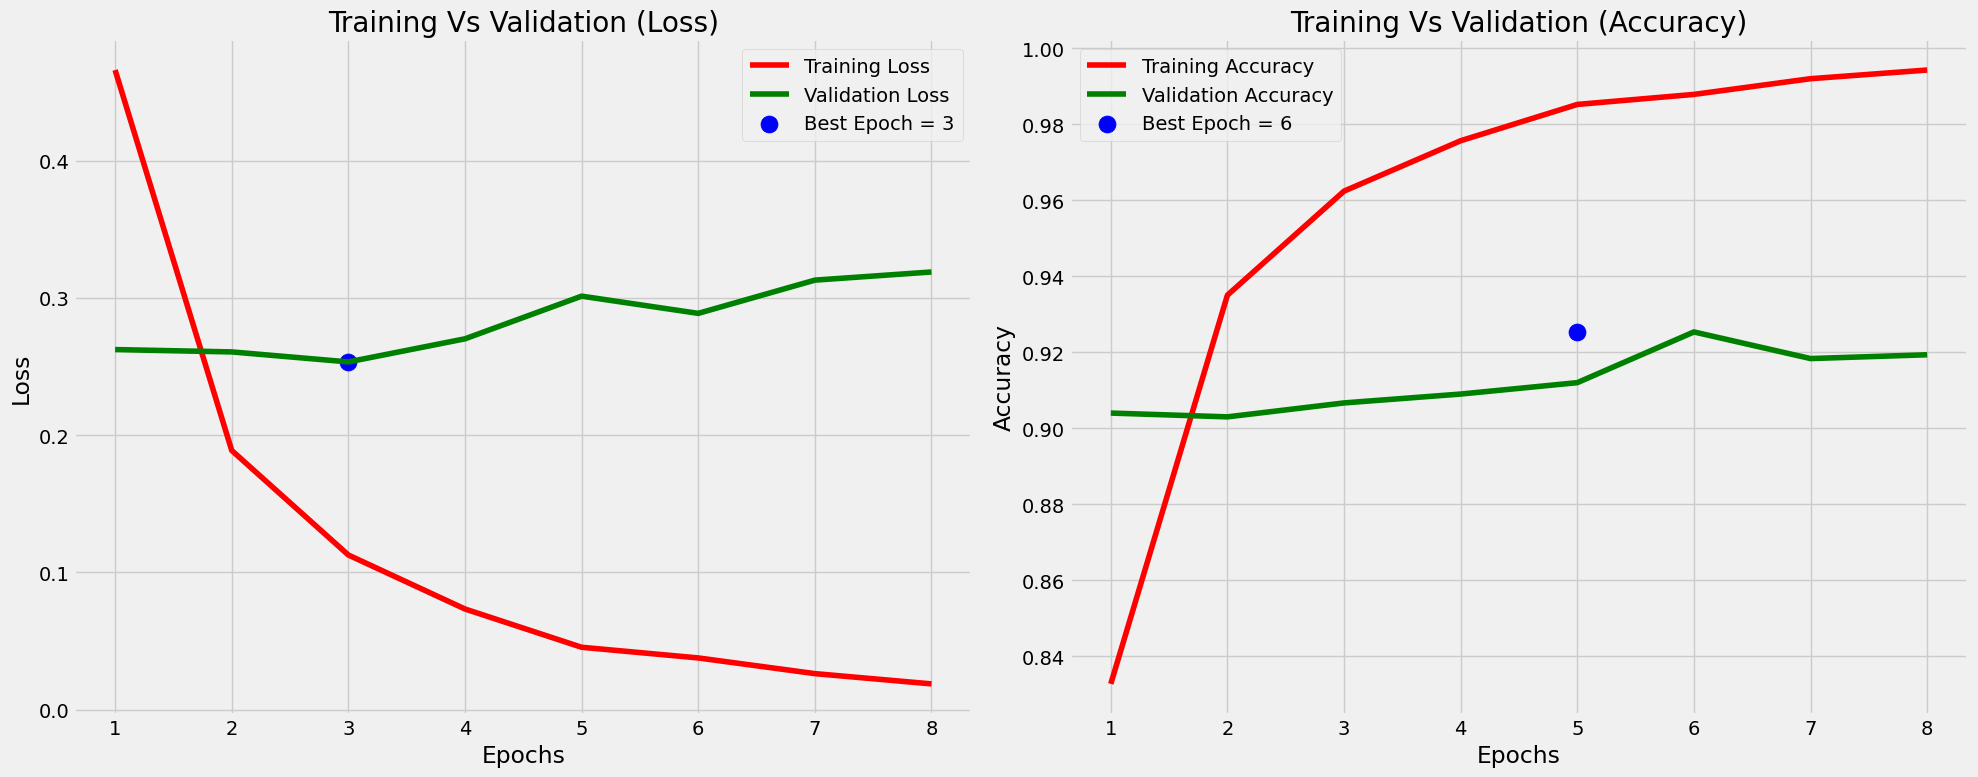

In [15]:
test_accuracy_and_loss(model3)
plot_accuracy_and_loss(history3)

# Prediction

### Prediction accuracy check on test data

In [16]:
predictions1, pred_lbl1 = prediction_accuracy(model1)

 8/94 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

W0000 00:00:1710386301.016435     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step
Model 1 Accuracy on test : 0.763


In [17]:
predictions2, pred_lbl2 = prediction_accuracy(model2)

 8/94 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

W0000 00:00:1710386312.779440     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step
Model 1 Accuracy on test : 0.79


In [18]:
predictions3, pred_lbl3 = prediction_accuracy(model3)

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step
Model 1 Accuracy on test : 0.9066666666666666


### Predictions of our best model on prediction data

229/229 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step


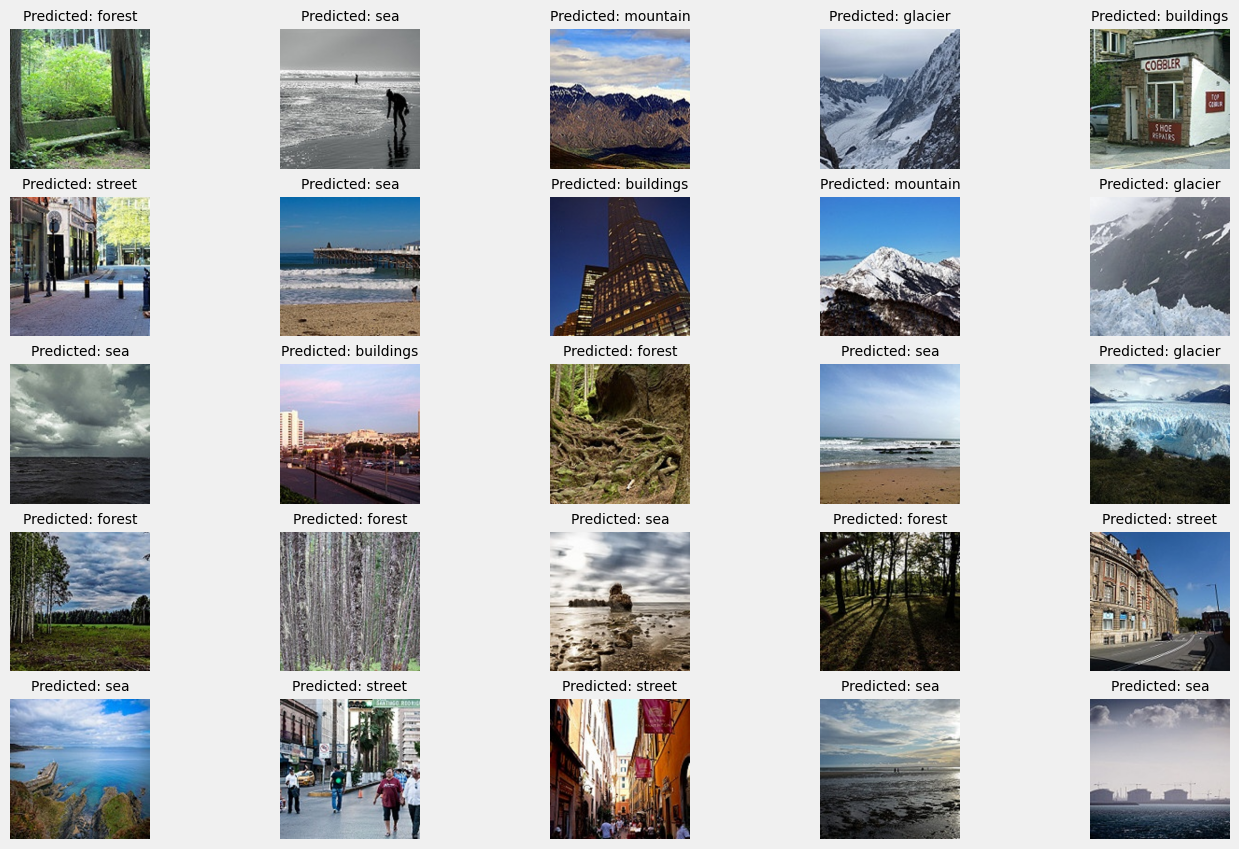

In [19]:
predictions = model3.predict(pred_img)    
pred_lbl = np.argmax(predictions, axis = 1)
# Visualize the predictions
plt.figure(figsize=(15, 10))
random_list2 = random.sample(range(7001), 25)
j=0
for i in random_list2: 
    plt.subplot(5, 5, j + 1)
    plt.imshow(pred_img[i], cmap='gray')
    label1 = get_key_from_value(labels, pred_lbl[i])
    label_code = pred_lbl[i]
    label_name = [key for key, value in labels.items() if value == label_code][0]
    
    plt.title(f"Predicted: {label_name}", fontsize=10)
    plt.axis('off')
    j+=1
plt.show()

# Confusion matrix and classification report

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


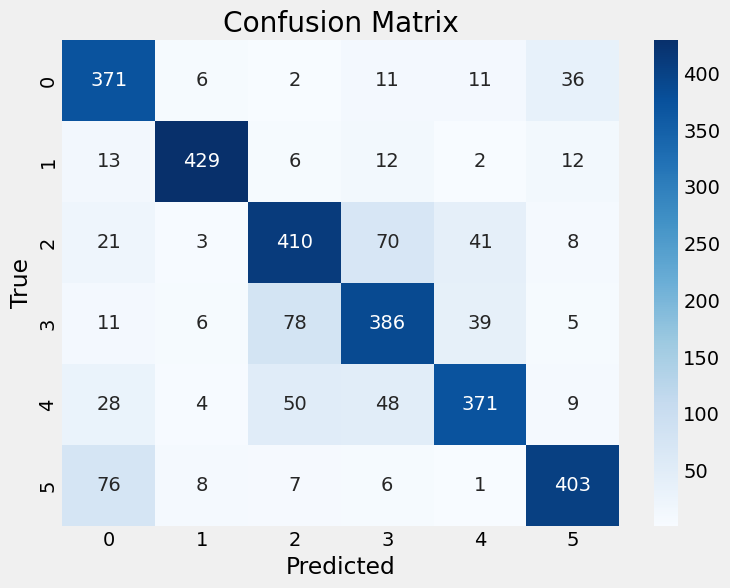


Classification Report:
              precision    recall  f1-score   support

   buildings       0.71      0.85      0.78       437
      forest       0.94      0.91      0.92       474
     glacier       0.74      0.74      0.74       553
    mountain       0.72      0.74      0.73       525
         sea       0.80      0.73      0.76       510
      street       0.85      0.80      0.83       501

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000



In [22]:
# Checking predicted labels on test set with actual labels
predictions = model2.predict(test_img)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_lbl, predicted_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Extract class labels in the correct order
class_labels = list(labels.keys())

# Print classification report
print("\nClassification Report:")
print(classification_report(test_lbl, predicted_classes, target_names=class_labels))

# Saving models

In [23]:
model1.save("InceptionModel1.h5") # Save the first model 
model2.save("InceptionModel2.h5") # Save the second model 
model3.save("InceptionModel3.h5") # Save the third model 

ValueError: Unable to synchronously create dataset (name already exists)